# International Air Passenger forecasting

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [26]:
air_passengers = pd.read_csv("data/AirPassengers.csv", header = 0, parse_dates = [0], 
                             names = ['Month', 'Passengers'], index_col = 0)


In [27]:
air_passengers.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [28]:
min(air_passengers.index)
max(air_passengers.index)

Timestamp('1960-12-01 00:00:00')

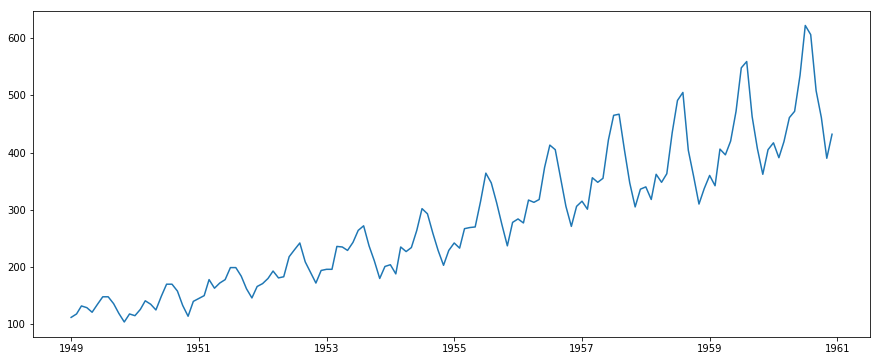

In [29]:
plt.plot(air_passengers)

In [30]:
log_air_passengers = np.log(air_passengers)

In [31]:
log_air_passengers.head()

,Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


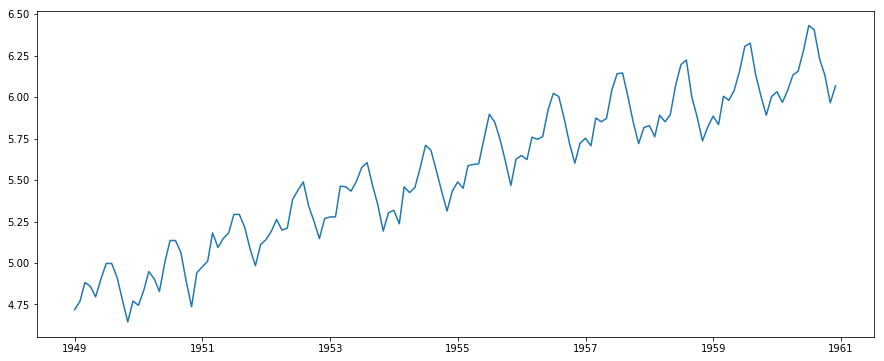

In [32]:
plt.plot(log_air_passengers)

In [33]:
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift()

In [34]:
log_air_passengers_diff.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022


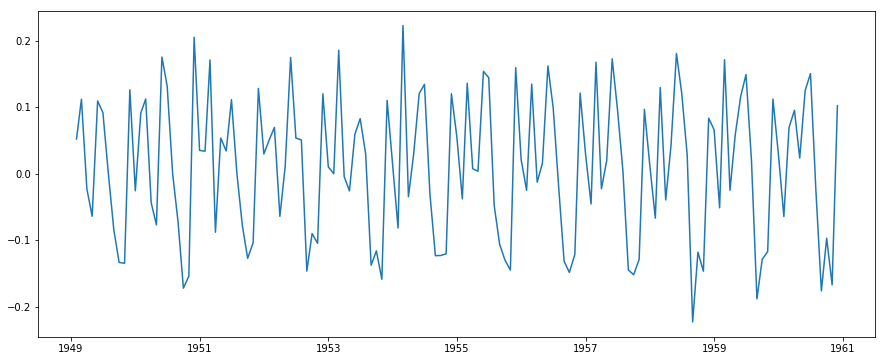

In [35]:
plt.plot(log_air_passengers_diff)

In [36]:
log_air_passengers_diff.dropna(inplace=True)

In [37]:
log_air_passengers_diff.head()

,Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484


In [38]:
log_air_passengers_diff.tail()

,Passengers
Month,
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083
1960-11-01,-0.167251
1960-12-01,0.102279


## check stationarity of the data using Dickey-Fuller test

In [14]:
from statsmodels.tsa.stattools import adfuller

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [39]:
useful_values_raw = adfuller(log_air_passengers_diff, autolag = 'AIC', regression = 'c')[:5]

useful_values = [v for v in useful_values_raw[:4]]

useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'],
                      useful_values_raw[4]['10%']])

pd.DataFrame({ 'Value':useful_values, 
              'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 
                       'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})

ValueError: too many values to unpack (expected 2)

In [40]:
from statsmodels.tsa.stattools import acf, pacf

In [41]:
lag_acf = acf(log_air_passengers_diff.values, nlags = 20)

In [42]:
lag_pacf = pacf(log_air_passengers_diff.values, nlags = 20)

/Users/manish/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


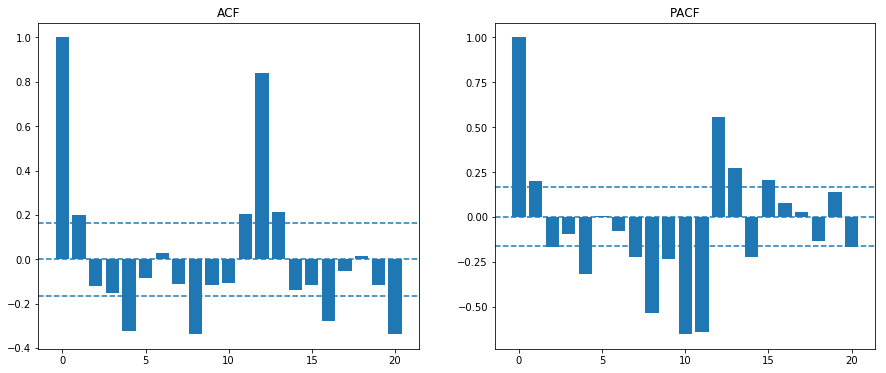

In [48]:
# Auto-Correlation Function to check MA process
plt.subplot(121) 
plt.bar(left = range(len(lag_acf)), height = lag_acf)
plt.axhline(y=0, linestyle='--')
plt.title('ACF')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')

# look at where the plot crosses the upper confidence interval for the first time
# for ACF this is 1 and gives us the p value

# Partial Auto-Correlation Function to check AR process
plt.subplot(122) 
plt.bar(left = range(len(lag_pacf)), height = lag_pacf)
plt.axhline(y=0, linestyle='--')
plt.title('PACF')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)), linestyle='--')

# look at where the plot crosses the upper confidence interval for the first time
# for PACF this is 2 and gives us the p value

## forecasting

In [49]:
from statsmodels.tsa.arima_model import ARIMA

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


ValueError: Cannot add integral value to Timestamp without freq.

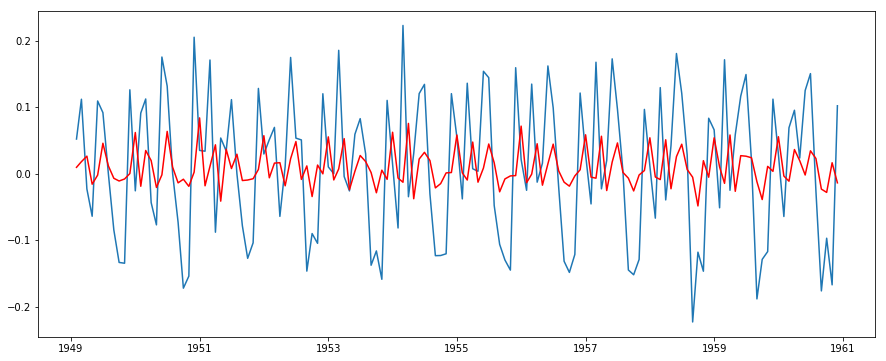

In [55]:
## AR model

# the parameter order has 3 components :
# 1. The number of Auto-Regressive Terms (p)
# 2. The number of differences taken (d)
# 3. The number of Moving Average Terms (q)

model = ARIMA(log_air_passengers, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  

plt.plot(log_air_passengers_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


ValueError: Cannot add integral value to Timestamp without freq.

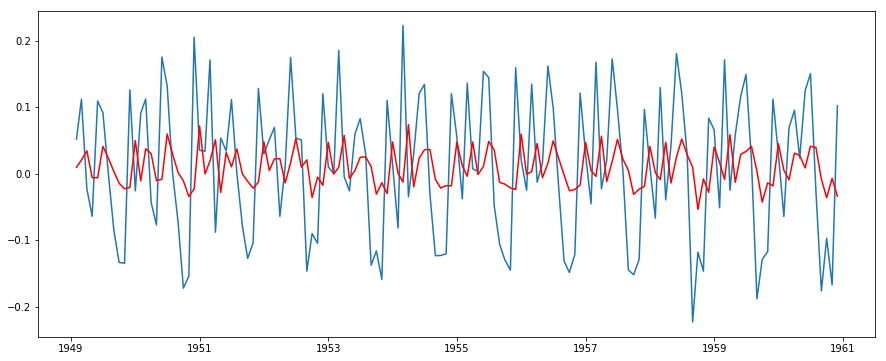

In [56]:
## MA model

model = ARIMA(log_air_passengers, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-log_air_passengers_diff)**2))

/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/manish/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


ValueError: Cannot add integral value to Timestamp without freq.

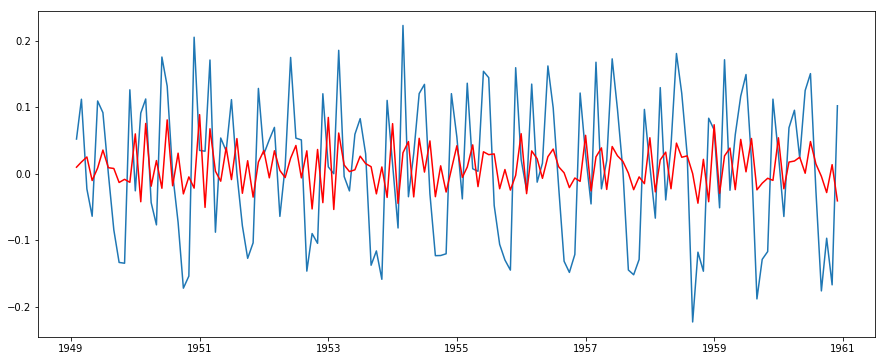

In [57]:
# ARIMA model
# try p = 1 or 2

model = ARIMA(log_air_passengers, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_air_passengers_diff)**2))

In [65]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009800
1949-03-01    0.017618
1949-04-01    0.025229
1949-05-01   -0.010225
1949-06-01    0.008528
dtype: float64


In [66]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009800
1949-03-01    0.027418
1949-04-01    0.052648
1949-05-01    0.042422
1949-06-01    0.050950
dtype: float64


In [67]:
# just getting the index
predictions_ARIMA_log = pd.Series(log_air_passengers.iloc[0], index=log_air_passengers.index)
predictions_ARIMA_log.head()

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
Name: 1949-01-01 00:00:00, dtype: float64

In [68]:
predictions_ARIMA_log = pd.Series(log_air_passengers.ix[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01         NaN
1949-02-01    0.009800
1949-03-01    0.027418
1949-04-01    0.052648
1949-05-01    0.042422
dtype: float64

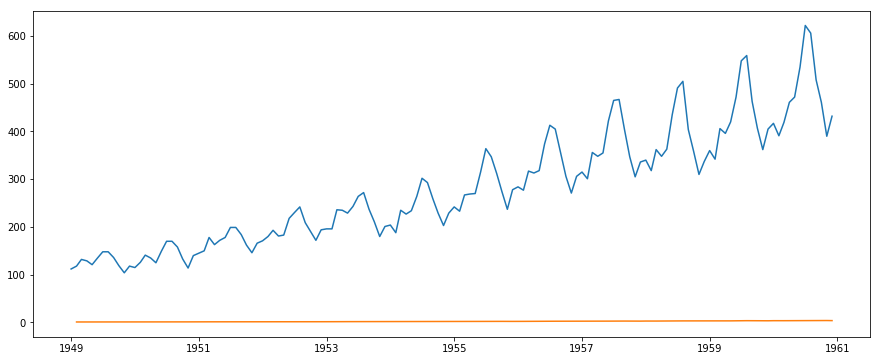

In [69]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(air_passengers)
plt.plot(predictions_ARIMA)